# Piecewise linear function

$$f(x_1, x_2) = f_1(x_1) + x1x2 $$

where:

$$ f(x_1) = \begin{cases}
    a_1 + b_1(x_1 - x_{1, from}) + 3x_1x_2 & \text{if } x_{1, from} \leq x_1 \leq x_{1, to} \\
    a_2 + b_2(x_1 - x_{2, from}) + 3x_1x_2 & \text{if } x_{2, from} \leq x_1 \leq x_{2, to} \\
    \vdots \\
    a_n + b_n(x_1 - x_{n, from}) + 3x_1x_2 & \text{if } x_{n, from} \leq x_1 \leq x_{n, to} \\
    0 & \text{otherwise}
    
\end{cases} $$

In [10]:
import numpy as np
import effector

class PiecewiseLinear:
    """
    Defines f(x1, x2) = f1(x1) + x1x2, where f1(x1) is a piecewise linear function
    """
    def __init__(self, params):
        self.params = params
        self.nof_parts = len(params)

    @staticmethod
    def _linear_part(x, a, b, x0):
        return a + b * (x[:, 0] - x0) + 3*x[:, 0] * x[:, 1]

    def _create_cond(self, x, i, s):
        """
        Finds the samples that are in the i-th piece of the piecewise linear function.
        Returns a boolean array of shape (n,) where n is the number of samples.
        """
        par = self.params
        if x.ndim >= 2:
            return np.logical_and(x[:, s] >= par[i]["from"], x[:, s] <= par[i]["to"])
        elif x.ndim == 1:
            return np.logical_and(x >= par[i]["from"], x <= par[i]["to"])

    def _create_piecewise_linear(self, i):
        """
        Creates a function that returns the i-th piece of the piecewise linear function.
        """
        def f(x):
            a = self.params[i]["a"]
            b = self.params[i]["b"]
            x0 = self.params[i]["from"]
            return a + b * (x[:, 0] - x0) + x[:, 0] * x[:, 1]
        return f

    def _create_piecewise_linear_der_x1(self, i):
        """
        Creates a function that returns the derivative of the piecewise linear function with respect to x1.
        """
        def f(x):
            b = self.params[i]["b"]
            return b + 3*x[:, 1]
        return f

    def _create_piecewise_linear_der_x2(self, i):
        """
        Creates a function that returns the derivative of the piecewise linear function with respect to x2.
        """
        def f(x):
            return 3*x[:, 0]
        return f

    def predict(self, x):
        """f(x1, x2) = f1(x1) + x1x2, where f1(x1) is a piecewise linear function
        """
        condlist = [self._create_cond(x, i, s=0) for i in range(self.nof_parts)]
        funclist = [self._create_piecewise_linear(i) for i in range(self.nof_parts)]

        y = np.zeros(x.shape[0])
        for i, cond in enumerate(condlist):
            y[cond] = funclist[i](x[cond, :])
        return y

    def jacobian(self, x):
        condlist = [self._create_cond(x, i, s=0) for i in range(self.nof_parts)]
        funclist1 = [self._create_piecewise_linear_der_x1(i) for i in range(self.nof_parts)]
        funclist2 = [self._create_piecewise_linear_der_x2(i) for i in range(self.nof_parts)]

        y1 = np.zeros(x.shape[0])
        y2 = np.zeros(x.shape[0])
        for i, cond in enumerate(condlist):
            y1[cond] = funclist1[i](x[cond, :])
            y2[cond] = funclist2[i](x[cond, :])

        return np.stack([y1, y2], axis=-1)


class GeneratingDist:
    """
    x1 ~ U(x1_min, x1_max)
    x2 ~ N(0, x2_sigma)
    """

    def __init__(self, x1_min, x1_max, x2_sigma):
        self.x1_min = x1_min
        self.x1_max = x1_max
        self.x2_sigma = x2_sigma

        self.axis_limits = np.array([[x1_min, x1_max], [-4*x2_sigma, 4 * x2_sigma]]).T

    def generate(self, N):
        x1 = np.concatenate((np.array([self.x1_min]),
                             np.random.uniform(self.x1_min, self.x1_max, size=int(N-2)),
                             np.array([self.x1_max])))
        x2 = np.random.normal(loc=np.zeros_like(x1), scale=self.x2_sigma)
        x = np.stack((x1, x2), axis=-1)
        return x


np.random.seed(21)
params = [
    {"a": 0.0, "b": 10, "from": 0.0, "to": 0.25},
    {"a": 2.5, "b": -10.0, "from": 0.25, "to": 0.5},
    {"a": 0.0, "b": 5.0, "from": 0.5, "to": 0.75},
    {"a": 1.25, "b": -5.0, "from": 0.75, "to": 1},
    {"a": 0, "b": 0, "from": 1, "to": 1.5},
    ]

model = PiecewiseLinear(params)


In [13]:
x1_min = 0
x1_max = 1.5
x2_sigma = 1
gen_dist = GeneratingDist(x1_min, x1_max, x2_sigma)
X = gen_dist.generate(N=500)
X_jac = model.jacobian(X)


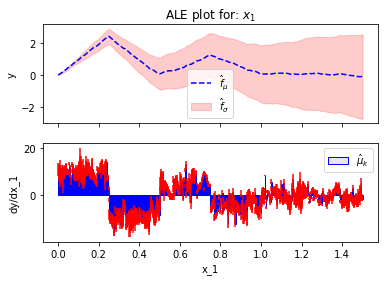

In [16]:
dale = effector.RHALE(data=X, model=model.predict, model_jac=model.jacobian, axis_limits=gen_dist.axis_limits)
dale.fit(features=0, binning_method=effector.binning_methods.Fixed(nof_bins=1000, min_points_per_bin=0))
dale.plot(feature=0, uncertainty=True)

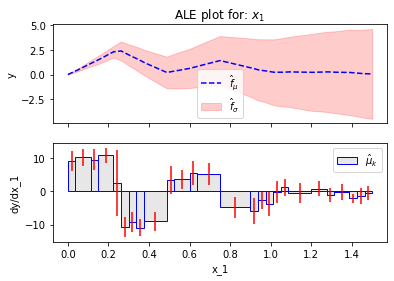

In [17]:

dale = effector.RHALE(data=X, model=model.predict, model_jac=model.jacobian, axis_limits=gen_dist.axis_limits)
dale.fit(features="all", binning_method=effector.binning_methods.DynamicProgramming(max_nof_bins=40))
dale.plot(feature=0, uncertainty=True)

